<a href="https://colab.research.google.com/github/tonu1990/AI_CV_Projects/blob/main/Pill_Detection_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
# Import libraries
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Define the path for the defect-free training images
train_path = '/content/drive/MyDrive/SelfLearning_AI/Implementation_AutoEncoderDecoder/train/good'

# Use glob to get a list of all image file paths (assuming png format)
train_image_paths = glob.glob(os.path.join(train_path, '*.png'))

# Check how many images were found
print("Number of training images found:", len(train_image_paths))


Number of training images found: 219


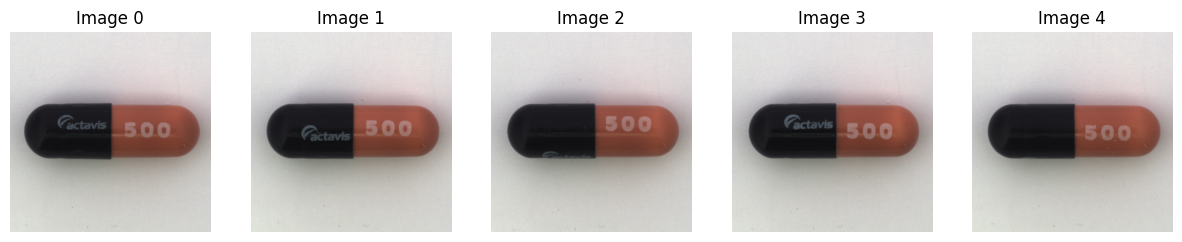

In [3]:
# Function to load and display a few sample images
def display_sample_images(image_paths, sample_size=5):
    sample_paths = image_paths[:sample_size]  # Pick the first few images
    plt.figure(figsize=(15, 3))
    for i, img_path in enumerate(sample_paths):
        img = Image.open(img_path)
        plt.subplot(1, sample_size, i+1)
        plt.imshow(img)
        plt.title(f"Image {i}")
        plt.axis('off')
    plt.show()

# Display sample images from the training set
display_sample_images(train_image_paths, sample_size=5)


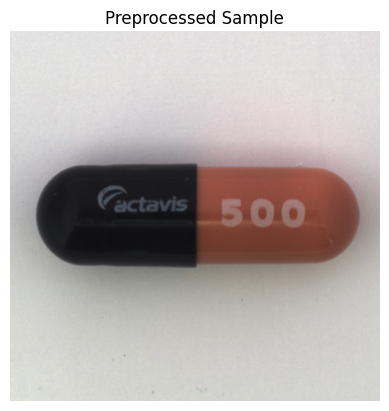

In [4]:
# Define image size for resizing
IMG_SIZE = (512, 512)

def preprocess_image(image_path, img_size=IMG_SIZE):
    # Open the image and convert to RGB (in case it is not)
    img = Image.open(image_path).convert('RGB')
    # Resize image
    img = img.resize(img_size)
    # Convert image to numpy array and normalize to [0, 1]
    img_array = np.array(img) / 255.0
    return img_array

# Process a single image for testing
sample_image = preprocess_image(train_image_paths[0])
plt.imshow(sample_image)
plt.title("Preprocessed Sample")
plt.axis('off')
plt.show()


In [6]:
# Preprocess all training images
def load_and_preprocess_images(image_paths, img_size=IMG_SIZE):
    images = []
    for path in image_paths:
        img_array = preprocess_image(path, img_size)
        images.append(img_array)
    return np.array(images)

# Load all training images into a NumPy array
train_images = load_and_preprocess_images(train_image_paths, IMG_SIZE)
print("Training dataset shape:", train_images.shape)


Training dataset shape: (219, 512, 512, 3)


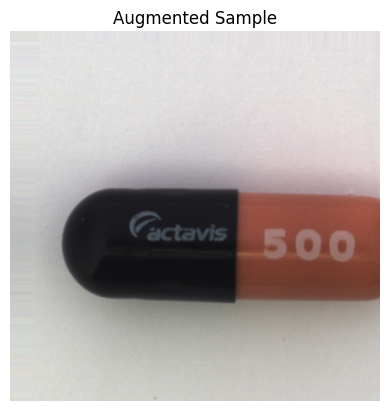

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a simple augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=10 ,    # small rotations
    width_shift_range=0.1 , # slight horizontal shifts
    height_shift_range=0.1 , # slight vertical shifts
    zoom_range=0.1 ,

)

# Example: Generate and display one augmented image
sample_image_expanded = np.expand_dims(train_images[0], 0)  # Expand dims for batch size
augmented_iter = datagen.flow(sample_image_expanded, batch_size=1)

augmented_image = next(augmented_iter)[0]

augmented = next(augmented_iter)[0]

plt.imshow(augmented_image)
plt.title("Augmented Sample")
plt.axis('off')
plt.show()


In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Define input shape for 512x512 RGB images
inputs = Input(shape=(512, 512, 3))

# ---------------------
# Encoder
# ---------------------
# Block 1
c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)  # 256x256

# Block 2
c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)  # 128x128

# Block 3
c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)  # 64x64

# Block 4
c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
p4 = MaxPooling2D((2, 2))(c4)  # 32x32

# Bottleneck
c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

# ---------------------
# Decoder
# ---------------------
# Block 1: 32x32
u6 = UpSampling2D((2, 2))(c5)  # 64x64
u6 = Conv2D(256, (2, 2), activation='relu', padding='same')(u6)
merge6 = concatenate([u6, c4], axis=-1)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

# Block 2: 64x64
u7 = UpSampling2D((2, 2))(c6)  # 128x128
u7 = Conv2D(128, (2, 2), activation='relu', padding='same')(u7)
merge7 = concatenate([u7, c3], axis=-1)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

# Block 3: 128x128
u8 = UpSampling2D((2, 2))(c7)  # 256x256
u8 = Conv2D(64, (2, 2), activation='relu', padding='same')(u8)
merge8 = concatenate([u8, c2], axis=-1)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

# Block 4: 256x256
u9 = UpSampling2D((2, 2))(c8)  # 512x512
u9 = Conv2D(32, (2, 2), activation='relu', padding='same')(u9)
merge9 = concatenate([u9, c1], axis=-1)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

# Output Layer
outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)

# Build the Model
autoencoder = Model(inputs=inputs, outputs=outputs)
autoencoder.compile(optimizer='adam', loss='mse')

# Display model summary
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 64)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 512)    │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 64, 64, 256)    │        524,544 │ up_sampling2d[0][0]    │
├──────────────────────

 Total params: 7,760,163 (29.60 MB)

 Trainable params: 7,760,163 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
from sklearn.model_selection import train_test_split

# Assuming train_images is a NumPy array with shape (num_images, 512, 512, 3)
x_train, x_val = train_test_split(train_images, test_size=0.1, random_state=42)

print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)


Training set shape: (197, 512, 512, 3)
Validation set shape: (22, 512, 512, 3)


In [13]:
batch_size = 16
epochs = 100  # You can adjust this based on when your loss converges


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Stop training if validation loss doesn't improve for 5 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model based on validation loss
checkpoint = ModelCheckpoint('autoencoder_best.h5', monitor='val_loss', save_best_only=True)


In [15]:
history = autoencoder.fit(
    x_train, x_train,       # For autoencoders, input equals target output
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_val, x_val),
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0681

13/13 ━━━━━━━━━━━━━━━━━━━━ 248s 12s/step - loss: 0.0669 - val_loss: 0.0336
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0321

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0320 - val_loss: 0.0254
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0263

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0263 - val_loss: 0.0243
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0243

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0243 - val_loss: 0.0233
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0161

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0158 - val_loss: 0.0049
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0043

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0043 - val_loss: 0.0027
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0023

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0023 - val_loss: 0.0018
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0019

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0015

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0011

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 9.8905e-04

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 9.8352e-04 - val_loss: 8.5157e-04
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 7.1766e-04

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 7.1900e-04 - val_loss: 7.2437e-04
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 6.3269e-04

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 6.3118e-04 - val_loss: 6.2853e-04
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5.3968e-04

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 5.3841e-04 - val_loss: 4.9666e-04
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 4.4974e-04 - val_loss: 5.6980e-04
Epoch 16/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.2790e-04

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 4.2556e-04 - val_loss: 4.0845e-04
Epoch 17/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 3.2233e-04 - val_loss: 6.2320e-04
Epoch 18/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.7969e-04

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 3.7956e-04 - val_loss: 3.4883e-04
Epoch 19/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.2400e-04

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 3.2362e-04 - val_loss: 3.2621e-04
Epoch 20/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.9683e-04

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 2.9694e-04 - val_loss: 3.1044e-04
Epoch 21/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 2.8538e-04 - val_loss: 4.9024e-04
Epoch 22/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 3.8947e-04 - val_loss: 4.6438e-04
Epoch 23/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 3.3730e-04 - val_loss: 3.3562e-04
Epoch 24/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.1820e-04

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 3.1625e-04 - val_loss: 2.9114e-04
Epoch 25/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 2.5890e-04 - val_loss: 3.2474e-04
Epoch 26/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 2.8170e-04 - val_loss: 2.9779e-04
Epoch 27/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.5511e-04

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 2.5602e-04 - val_loss: 2.5294e-04
Epoch 28/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 3.9290e-04 - val_loss: 5.5899e-04
Epoch 29/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 4.2505e-04 - val_loss: 3.4003e-04
Epoch 30/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 3.7042e-04 - val_loss: 4.3511e-04
Epoch 31/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 2.9726e-04 - val_loss: 2.5455e-04
Epoch 32/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 2.2562e-04 - val_loss: 7.4576e-04


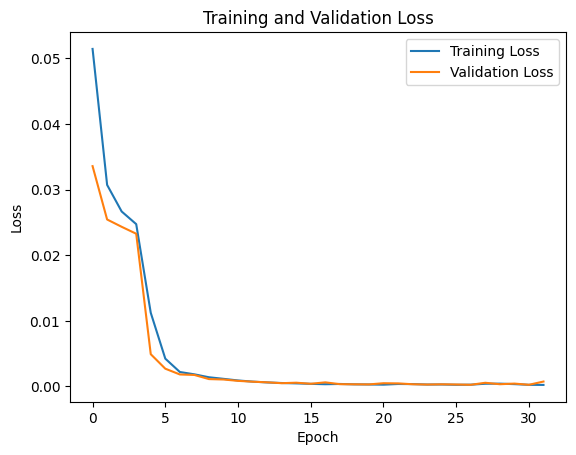

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [17]:
from tensorflow.keras.models import load_model
import tensorflow.keras.losses as losses

# Map "mse" to the MeanSquaredError loss function
autoencoder = load_model('/content/autoencoder_best.h5', custom_objects={'mse': losses.MeanSquaredError()})



1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


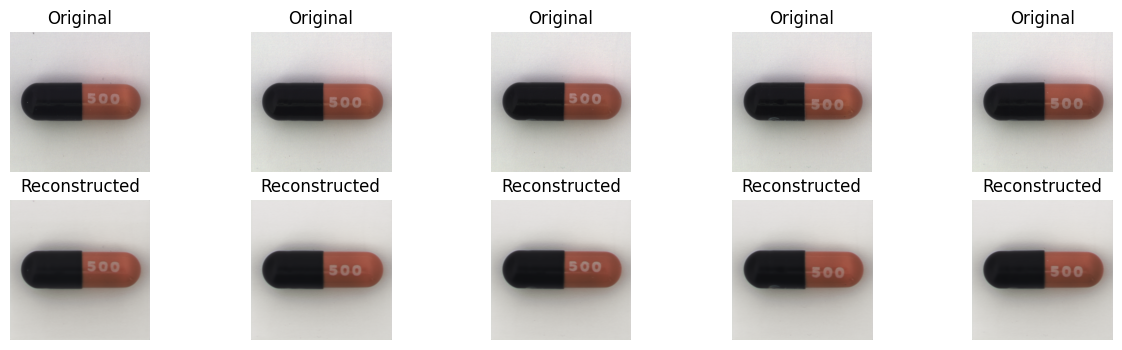

In [18]:
import matplotlib.pyplot as plt

# Select a few images from the validation set
n = 5
sample_images = x_val[:n]
reconstructed = autoencoder.predict(sample_images)

plt.figure(figsize=(15, 4))
for i in range(n):
    # Original image
    plt.subplot(2, n, i+1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(2, n, i+1+n)
    plt.imshow(reconstructed[i])
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()


In [19]:
import numpy as np

def compute_reconstruction_error(original, reconstructed):
    # Calculate mean squared error per image
    return np.mean(np.square(original - reconstructed), axis=(1,2,3))

# Compute errors for the validation set
val_reconstructions = autoencoder.predict(x_val)
errors = compute_reconstruction_error(x_val, val_reconstructions)

print("Reconstruction Error Statistics:")
print("Mean:", np.mean(errors))
print("Std:", np.std(errors))


1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step
Reconstruction Error Statistics:
Mean: 0.0002529369794730353
Std: 0.0002740454600012577


Step 4: Set an Anomaly Threshold

One common approach is to set the threshold as the mean plus a few standard deviations of the reconstruction errors from the defect-free (normal) validation set.

In [20]:
threshold = np.mean(errors) + 2 * np.std(errors)
print("Anomaly Threshold:", threshold)


Anomaly Threshold: 0.0008010278994755506


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


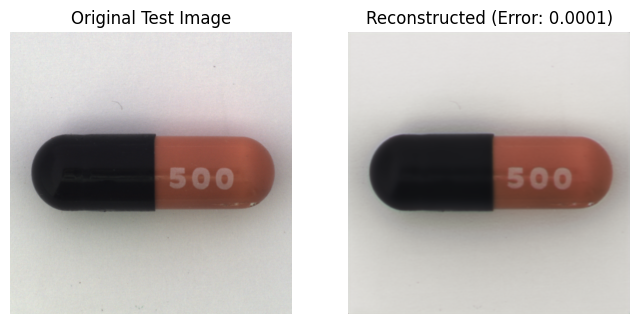

'Reconstructed (Error: 0.0001)'

In [21]:
# Assuming test_images is your test dataset loaded and preprocessed similarly
# For demonstration, let’s say you load a test image:
# (You should repeat this for multiple test cases from each defect category)

test_image = preprocess_image('/content/drive/MyDrive/SelfLearning_AI/Implementation_AutoEncoderDecoder/test/crack/000.png')
test_image_expanded = np.expand_dims(test_image, 0)
test_reconstruction = autoencoder.predict(test_image_expanded)
test_error = compute_reconstruction_error(test_image_expanded, test_reconstruction)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Original Test Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_reconstruction[0])
plt.title(f"Reconstructed (Error: {test_error[0]:.4f})")
plt.axis('off')
plt.show()

f"Reconstructed (Error: {test_error[0]:.4f})"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


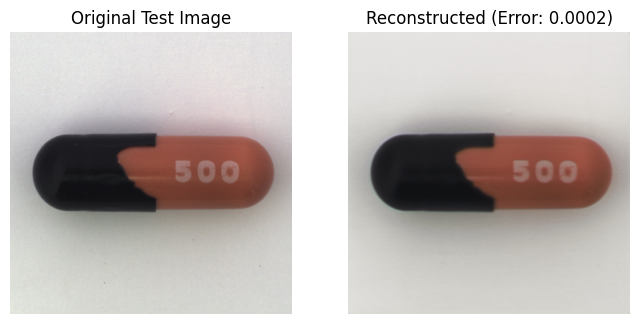

Reconstructed (Error: 0.0002)
Anomaly Threshold: 0.0008010278994755506


In [24]:
# Assuming test_images is your test dataset loaded and preprocessed similarly
# For demonstration, let’s say you load a test image:
# (You should repeat this for multiple test cases from each defect category)

test_image = preprocess_image('/content/drive/MyDrive/SelfLearning_AI/Implementation_AutoEncoderDecoder/test/crack/010.png')
test_image_expanded = np.expand_dims(test_image, 0)
test_reconstruction = autoencoder.predict(test_image_expanded)
test_error = compute_reconstruction_error(test_image_expanded, test_reconstruction)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Original Test Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_reconstruction[0])
plt.title(f"Reconstructed (Error: {test_error[0]:.4f})")
plt.axis('off')
plt.show()

print(f"Reconstructed (Error: {test_error[0]:.4f})")
print("Anomaly Threshold:", threshold)
if test_error[0] > threshold :
  print("Defective")

In [41]:
test_error[0]

0.00035964749479852257

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


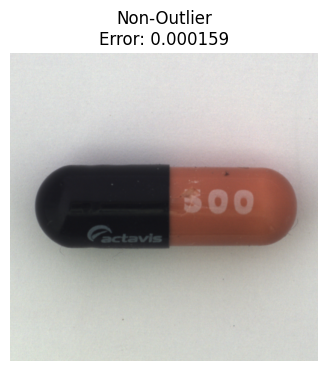

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


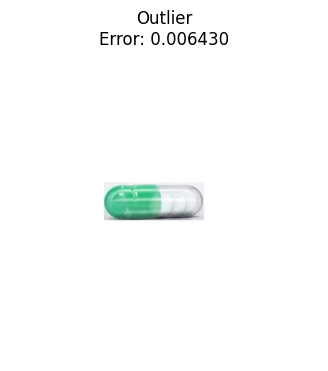

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


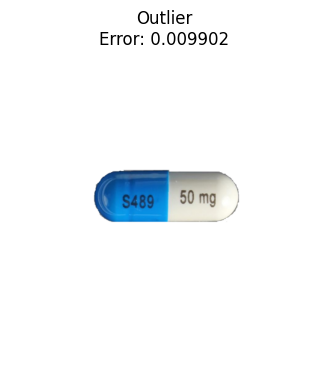

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


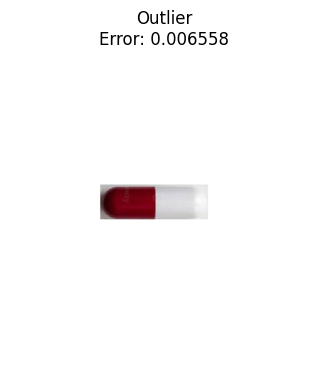

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


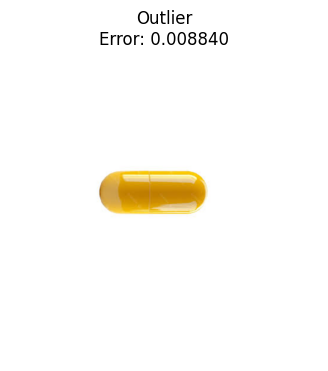

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


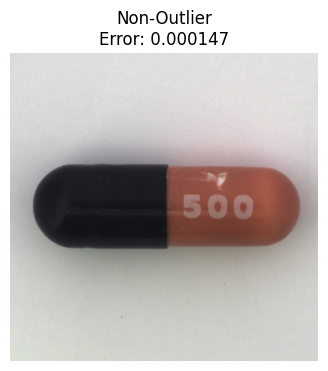

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


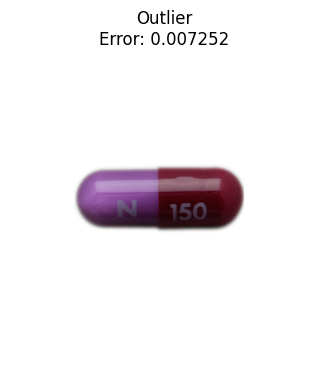

In [25]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



# Function to preprocess images (resize to 512x512 and normalize)
def preprocess_image(image_path, img_size=(512, 512)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img) / 255.0
    return img_array

# Get all pill images from the specified folder (assuming PNG format)
image_paths = glob.glob("/content/drive/MyDrive/SelfLearning_AI/Implementation_AutoEncoderDecoder/different_pill/*.png")

# Loop over each image, run through the autoencoder, and classify
for path in image_paths:
    # Preprocess the image
    img = preprocess_image(path)

    # Add batch dimension
    img_expanded = np.expand_dims(img, axis=0)

    # Get reconstruction from autoencoder
    reconstruction = autoencoder.predict(img_expanded)

    # Compute reconstruction error (mean squared error)
    error = np.mean(np.square(img - reconstruction[0]))

    # Classify based on the threshold
    label = "Outlier" if error > threshold else "Non-Outlier"

    # Display the image with the title indicating the classification and error value
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"{label}\nError: {error:.6f}")
    plt.axis('off')
    plt.show()
